In [72]:
# import timm
import torch.optim as optim
import torch.nn as nn
# model = timm.create_model('resnet18', in_chans=1, num_classes=1).float().to("mps")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

device = "mps"

class Net(nn.Module):
    def __init__(self, nf, nl):
        super().__init__()
        self.nf = nf
        self.nl = nl
        self.convs = nn.ModuleList() 
        n = (1, 4)
        for i in range(self.nl):
            self.convs.append(nn.Conv2d(n[0], n[1], (self.nf, 4), padding="same"))
            n = (n[1], n[1]*2)
        self.conv_valid = nn.Conv2d(n[0], n[1], (self.nf, 4), padding="valid")
        self.pool = nn.MaxPool2d((1, 2), (1, 2))
        self.fc = nn.Linear(n[1], 1)

    def forward(self, x):
        n = (1, 4)
        for i in range(self.nl):
            x = self.convs[i](x)
            x = self.pool(F.relu(x))
            n = (n[1], n[1]*2)
        x = F.relu(self.conv_valid(x))
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc(x))
        return x
model = Net(7, 3)#.to(device)
print(summary(model, (1, 1, 7, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [1, 4, 7, 32]             116
├─MaxPool2d: 1-2                         [1, 4, 7, 16]             --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-2                       [1, 8, 7, 16]             904
├─MaxPool2d: 1-4                         [1, 8, 7, 8]              --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [1, 16, 7, 8]             3,600
├─MaxPool2d: 1-6                         [1, 16, 7, 4]             --
├─Conv2d: 1-7                            [1, 32, 1, 1]             14,368
├─Linear: 1-8                            [1, 1]                    33
Total params: 19,021
Trainable params: 19,021
Non

In [73]:
def get_data(X, y, test_split=0.25):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, 0, -2, 0]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test, profs_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test], y[ids_test]
    tf_test = X_test[:, 0, -1, 0]
    X_train = X_train[:, :, :-2, :]
    X_test = X_test[:, :, :-2, :]
    
    y_train = np.tanh(y_train)
    y_test = np.tanh(y_test)
    
    return X_train, X_test, y_train, y_test, profs_test, tf_test

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.img_labels = y
        self.imgs = X

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        return image, label

In [44]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle
optimization/btest018.pickle
optimization/btest019.pickle
optimization/btest020.pickle
optimization/btest021.pickle
optimization/btest022.pickle
optimization/btest023.pickle
optimization/btest024.pickle
optimization/btest025.pickle
optimization/btest026.pickle
optimization/btest027.pickle
optimization/btest028.pickle
optimization/btest029.pickle
optimization/btest030.pickle
optimization/btest031.pickle
optimization/btest032.pickle
optimization/btest033.pickle
optimization/b

In [74]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from indicators import ZigZag


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 8
tfdict = {"M5":0, "M15":1, "H1":2}
zz = ZigZag()
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[2:]:
        f, _ = mw(pos.open_indx)
        fo = f.Open[:-2]/f.Open[-2]
        fc = f.Close[:-2]/f.Open[:-2]
        fh = f.High[:-2]/f.Open[:-2]
        fl = f.Low[:-2]/f.Open[:-2]
        fv = f.Volume[:-2]/f.Volume[-2] if f.Volume[-2] != 0 else np.ones_like(f.Volume[:-2])
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir > 0:
            x = np.vstack([fc, fo, fl, fh])
        else:
            x = np.vstack([2-fc, 2-fo, 2-fl, 2-fh])
        x = x*100 - 100
        # print(x.flatten())
        x = np.vstack([x, fv])
        x = np.vstack([x, np.ones(x.shape[1])*btest.cfg.stops_processor.func.cfg.sl/6+1])
        x = np.vstack([x, np.ones(x.shape[1])*btest.cfg.trailing_stop_rate/0.04+1])
        x = np.vstack([x, np.ones(x.shape[1])*odate])
        x = np.vstack([x, np.ones(x.shape[1])*tfdict[btest.cfg.period]])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)

SBER 467
ROSN 301
LKOH 324
GMKN 307
GAZP 318
SBER 319
ROSN 217
LKOH 219
GMKN 218
GAZP 227
SBER 256
ROSN 189
LKOH 175
GMKN 173
GAZP 181
SBER 634
ROSN 414
LKOH 445
GMKN 415
GAZP 409
SBER 469
ROSN 312
LKOH 327
GMKN 313
GAZP 317
SBER 406
ROSN 271
LKOH 278
GMKN 261
GAZP 275
SBER 834
ROSN 524
LKOH 554
GMKN 540
GAZP 542
SBER 661
ROSN 436
LKOH 450
GMKN 445
GAZP 435
SBER 577
ROSN 390
LKOH 409
GMKN 370
GAZP 388
(16902, 1, 9, 8) (16902,)


(12671, 1, 7, 8) (4231, 1, 7, 8) (4231,)


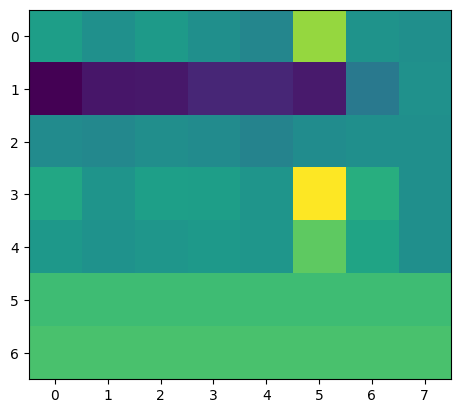

In [75]:
np.random.seed(1000)
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y)
print(X_train.shape, X_test.shape, tf_test.shape)
plt.imshow(X_train[0][0][:])

In [79]:
def train(model_builder, batch_size):
    trainloader = torch.utils.data.DataLoader(CustomImageDataset(X_train, y_train), 
                                              batch_size=batch_size, 
                                              shuffle=True)
    model = model_builder(7, 1).to(device)
    # print(summary(model, (1, 6, 32)))
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(30):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float().to(device))
            loss = criterion(outputs[:, 0], labels.float().to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        # loss_test = criterion(model(torch.tensor(X_test).float().to(device)), 
        #                       torch.tensor(y_test).float().to(device))
        # print(f"[{epoch + 1:03d}, {i + 1:5d}] loss train: {running_loss / (i + 1):.3f} | test: {loss_test / (i + 1):.3f}")
        running_loss = 0.0
    return model

In [81]:
nitrers = 10
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    np.random.seed(i)
    X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y)
    model = train(Net, 256)
    
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()
    metrics[1, i] = mean_absolute_error(p_test, y_test)
    
    threshold = np.percentile(p_train, 10)
    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
    pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
    gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)
    f1_mean = metrics.mean(axis=1, where=metrics!=0)
    pprofs_mean_tot = np.nanmean(pprofs_mean)
    gprofs_mean_tot = np.nanmean(gprofs_mean)
    print("-------------------------------------------------")
    print(gprofs_mean, " -> ", pprofs_mean)
    print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
    print(f"av. profit boost: {(pprofs_mean_tot - gprofs_mean_tot)/abs(gprofs_mean_tot)}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
# plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
plt.plot([0, 100], [threshold, threshold])

000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 :+2224.1 -> +2246.9 OK
000 mae_train: 0.76 mae_test: 0.78
-------------------------------------------------
[          nan           nan 2224.08520508]  ->  [          nan           nan 2246.85888672]
mae_train: 0.76 mae_test: 0.78 ratio: 1.03
av. profit boost: 0.010239572471696306


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_37844/1433817688.py:27: RuntimeWarning: Mean of empty slice.
  pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
/Users/andrybin/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_37844/1433817688.py:28: RuntimeWarning: Mean of empty slice.
  gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)


KeyboardInterrupt: 

In [49]:
(p_test<threshold).sum()

127

In [50]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

AttributeError: 'Net' object has no attribute 'feature_importances_'

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction

array([[0.49287947, 0.50712053]])